# NYC Subway Ridership Forecasting via LSTM Model

Author: Andrew Jackson<br>
Version: FINAL<br>
Date: 12/3/2024

### Imports and Dependencies

In [1]:
#System level imports
import sys
import os
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

In [2]:
#Dataframe and manipulation imports
import numpy as np
import pandas as pd

#Preprocessing, metrics and scaler imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from scipy import stats

#LSTM time series model imports
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

#Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import branca
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.io as pio


## Exploratory Data Analysis (EDA)

Import MTA hourly ridership data from 2022 and 2023, which has been pre-processed from 2020 onward data. Later years chosen to isolate ridership trends with less impact from COVID-19 restrictions.

In [3]:
df_hr_22 = pd.read_pickle(r'D:\capstone_F24\data\MTA_Subway_Hourly_Ridership_2022.pkl')

df_hr_23 = pd.read_pickle(r'D:\capstone_F24\data\MTA_Subway_Hourly_Ridership_2023.pkl')


In [4]:
display(df_hr_22)

display(df_hr_23)


,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference
0,2022-02-17 22:00:00,subway,59,9 Av (D),Brooklyn,omny,OMNY - Full Fare,4,0,40.646294,-73.994320,POINT (-73.99432 40.646294)
1,2022-03-10 23:00:00,subway,404,28 St (6),Manhattan,omny,OMNY - Other,1,0,40.743070,-73.984260,POINT (-73.98426 40.74307)
2,2022-10-05 21:00:00,subway,272,"36 St (M,R)",Queens,omny,OMNY - Full Fare,14,0,40.752040,-73.928780,POINT (-73.92878 40.75204)
3,2022-10-05 22:00:00,subway,420,"219 St (2,5)",Bronx,omny,OMNY - Full Fare,5,0,40.883896,-73.862630,POINT (-73.86263 40.883896)
4,2022-10-05 10:00:00,subway,218,"167 St (B,D)",Bronx,omny,OMNY - Full Fare,78,6,40.833770,-73.918440,POINT (-73.91844 40.83377)
...,...,...,...,...,...,...,...,...,...,...,...,...
22514157,2022-02-06 20:00:00,subway,99,"Lorimer St (M,J)",Brooklyn,metrocard,Metrocard - Full Fare,8,0,40.703870,-73.947410,POINT (-73.94741 40.70387)
22514158,2022-02-06 12:00:00,subway,95,"Gates Av (J,Z)",Brooklyn,metrocard,Metrocard - Unlimited 30-Day,16,0,40.689630,-73.922270,POINT (-73.92227 40.68963)
22514159,2022-12-28 22:00:00,subway,245,18 Av (F),Brooklyn,omny,OMNY - Full Fare,5,1,40.629753,-73.976974,POINT (-73.976974 40.629753)
22514160,2022-03-24 14:00:00,subway,217,"170 St (B,D)",Bronx,omny,OMNY - Full Fare,61,2,40.839306,-73.913400,POINT (-73.9134 40.839306)


,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference
0,2023-09-02 15:00:00,subway,300,191 St (1),Manhattan,omny,OMNY - Full Fare,119,1,40.855225,-73.929410,POINT (-73.92941 40.855225)
1,2023-09-02 19:00:00,subway,304,145 St (1),Manhattan,omny,OMNY - Full Fare,97,2,40.826550,-73.950360,POINT (-73.95036 40.82655)
2,2023-09-27 08:00:00,subway,97,"Myrtle Av (M,J,Z)",Brooklyn,metrocard,Metrocard - Unlimited 30-Day,141,0,40.697210,-73.935650,POINT (-73.93565 40.69721)
3,2023-09-27 21:00:00,subway,56,Ocean Pkwy (Q),Brooklyn,metrocard,Metrocard - Other,3,0,40.576313,-73.968500,POINT (-73.9685 40.576313)
4,2023-09-27 14:00:00,subway,159,"81 St-Museum of Natural History (C,B)",Manhattan,metrocard,Metrocard - Unlimited 30-Day,46,0,40.781433,-73.972145,POINT (-73.972145 40.781433)
...,...,...,...,...,...,...,...,...,...,...,...,...
25588026,2023-09-02 22:00:00,subway,254,Jamaica-179 St (F),Queens,metrocard,Metrocard - Other,19,2,40.712646,-73.783810,POINT (-73.78381 40.712646)
25588027,2023-09-02 07:00:00,subway,254,Jamaica-179 St (F),Queens,omny,OMNY - Full Fare,106,38,40.712646,-73.783810,POINT (-73.78381 40.712646)
25588028,2023-09-02 17:00:00,subway,376,Brook Av (6),Bronx,omny,OMNY - Full Fare,36,1,40.807568,-73.919240,POINT (-73.91924 40.807568)
25588029,2023-09-02 12:00:00,subway,297,215 St (1),Manhattan,metrocard,Metrocard - Other,6,0,40.869446,-73.915276,POINT (-73.915276 40.869446)


In [5]:
display(df_hr_22.info())

display(df_hr_22.dtypes)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22514162 entries, 0 to 22514161
Data columns (total 12 columns):
 #   Column               Dtype         
---  ------               -----         
 0   transit_timestamp    datetime64[ns]
 1   transit_mode         object        
 2   station_complex_id   object        
 3   station_complex      object        
 4   borough              object        
 5   payment_method       object        
 6   fare_class_category  object        
 7   ridership            object        
 8   transfers            object        
 9   latitude             float64       
 10  longitude            float64       
 11  Georeference         object        
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 2.0+ GB


None

transit_timestamp      datetime64[ns]
transit_mode                   object
station_complex_id             object
station_complex                object
borough                        object
payment_method                 object
fare_class_category            object
ridership                      object
transfers                      object
latitude                      float64
longitude                     float64
Georeference                   object
dtype: object

### QUESTION: Are there stations not included in both datasets?

In [6]:
stations_22 = df_hr_22['station_complex_id'].unique()
print(f'There are {len(stations_22)} unique stations in 2022 {stations_22[:10]}...')

stations_23 = df_hr_23['station_complex_id'].unique()
print(f'There are {len(stations_23)} unique stations in 2022 {stations_23[:10]}...')

# Convert lists to sets for efficient comparison
station_22_set = set(stations_22)
station_23_set = set(stations_23)

# Find exclusive stations for each year
exclusive_to_22 = station_22_set - station_23_set
exclusive_to_23 = station_23_set - station_22_set

print("Stations exclusive to 2022:", exclusive_to_22)
print("Stations exclusive to 2023:", exclusive_to_23)


There are 854 unique stations in 2022 ['59' '404' '272' '420' '218' '193' '165' '398' '61' '75']...
There are 853 unique stations in 2022 ['300' '304' '97' '56' '159' '129' '53' '52' '276' '65']...
Stations exclusive to 2022: {98}
Stations exclusive to 2023: set()


### TRANSFORM DATA: grouped data by station complex ID and timestamp

In [7]:
# Convert transit_timestamp to datetime
df_hr_22['transit_timestamp'] = pd.to_datetime(df_hr_22['transit_timestamp'])
df_hr_22['ridership'] = df_hr_22['ridership'].str.replace(',', '').astype(int)

# Convert transit_timestamp to datetime
df_hr_23['transit_timestamp'] = pd.to_datetime(df_hr_23['transit_timestamp'])
df_hr_23['ridership'] = df_hr_23['ridership'].str.replace(',', '').astype(int)


In [8]:
# Group by `station_complex_id` and `transit_timestamp` to sum up ridership
hourly_ridership_22 = df_hr_22.groupby(['station_complex_id', 'transit_timestamp']).agg(
    {
        'ridership': 'sum',
        'station_complex': 'first', # Keep station info
        'borough': 'first',
        'latitude': 'first',
        'longitude': 'first'
    }
).reset_index()

# Group by `station_complex_id` and `transit_timestamp` to sum up ridership
hourly_ridership_23 = df_hr_23.groupby(['station_complex_id', 'transit_timestamp']).agg(
    {
        'ridership': 'sum',
        'station_complex': 'first',
        'borough': 'first',
        'latitude': 'first',
        'longitude': 'first'
    }
).reset_index()

display(hourly_ridership_22)
display(hourly_ridership_23)


,station_complex_id,transit_timestamp,ridership,station_complex,borough,latitude,longitude
0,1,2022-02-19 00:00:00,58,"Astoria-Ditmars Blvd (N,W)",Queens,40.775036,-73.91203
1,1,2022-02-19 01:00:00,24,"Astoria-Ditmars Blvd (N,W)",Queens,40.775036,-73.91203
2,1,2022-02-19 02:00:00,2,"Astoria-Ditmars Blvd (N,W)",Queens,40.775036,-73.91203
3,1,2022-02-19 03:00:00,7,"Astoria-Ditmars Blvd (N,W)",Queens,40.775036,-73.91203
4,1,2022-02-19 04:00:00,18,"Astoria-Ditmars Blvd (N,W)",Queens,40.775036,-73.91203
...,...,...,...,...,...,...,...
3484081,TRAM2,2022-12-31 19:00:00,79,RI Tramway (Roosevelt),Manhattan,40.757340,-73.95412
3484082,TRAM2,2022-12-31 20:00:00,60,RI Tramway (Roosevelt),Manhattan,40.757340,-73.95412
3484083,TRAM2,2022-12-31 21:00:00,57,RI Tramway (Roosevelt),Manhattan,40.757340,-73.95412
3484084,TRAM2,2022-12-31 22:00:00,59,RI Tramway (Roosevelt),Manhattan,40.757340,-73.95412


,station_complex_id,transit_timestamp,ridership,station_complex,borough,latitude,longitude
0,1,2023-01-04 00:00:00,32,"Astoria-Ditmars Blvd (N,W)",Queens,40.775036,-73.91203
1,1,2023-01-04 01:00:00,21,"Astoria-Ditmars Blvd (N,W)",Queens,40.775036,-73.91203
2,1,2023-01-04 02:00:00,8,"Astoria-Ditmars Blvd (N,W)",Queens,40.775036,-73.91203
3,1,2023-01-04 03:00:00,14,"Astoria-Ditmars Blvd (N,W)",Queens,40.775036,-73.91203
4,1,2023-01-04 04:00:00,57,"Astoria-Ditmars Blvd (N,W)",Queens,40.775036,-73.91203
...,...,...,...,...,...,...,...
3844186,TRAM2,2023-12-31 19:00:00,281,RI Tramway (Roosevelt),Manhattan,40.757340,-73.95412
3844187,TRAM2,2023-12-31 20:00:00,186,RI Tramway (Roosevelt),Manhattan,40.757340,-73.95412
3844188,TRAM2,2023-12-31 21:00:00,157,RI Tramway (Roosevelt),Manhattan,40.757340,-73.95412
3844189,TRAM2,2023-12-31 22:00:00,106,RI Tramway (Roosevelt),Manhattan,40.757340,-73.95412


In [9]:
hourly_ridership_22.to_csv('hrly_22.csv')
hourly_ridership_23.to_csv('hrly_23.csv')


### TRANSFORM DATA: Convert long time series to wide time series

In [10]:
# Pivot the table to create wide format with `transit_timestamp` as columns
wide_data_22 = hourly_ridership_22.pivot(
    index=['station_complex_id', 'station_complex', 'borough', 'latitude', 'longitude'],
    columns='transit_timestamp',
    values='ridership'
).reset_index()

# Flatten the column hierarchy created by pivot
wide_data_22.columns.name = None
wide_data_22.columns = [f"{col}" for col in wide_data_22.columns]
display(wide_data_22)

,station_complex_id,station_complex,borough,latitude,longitude,2022-02-01 00:00:00,2022-02-01 01:00:00,2022-02-01 02:00:00,2022-02-01 03:00:00,2022-02-01 04:00:00,...,2022-12-31 14:00:00,2022-12-31 15:00:00,2022-12-31 16:00:00,2022-12-31 17:00:00,2022-12-31 18:00:00,2022-12-31 19:00:00,2022-12-31 20:00:00,2022-12-31 21:00:00,2022-12-31 22:00:00,2022-12-31 23:00:00
0,1,"Astoria-Ditmars Blvd (N,W)",Queens,40.775036,-73.912030,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"Astoria Blvd (N,W)",Queens,40.770260,-73.917850,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,"30 Av (N,W)",Queens,40.766780,-73.921480,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,"Broadway (N,W)",Queens,40.761820,-73.925510,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,"36 Av (N,W)",Queens,40.756805,-73.929570,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,97,"Myrtle Av (M,J,Z)",Brooklyn,40.697210,-73.935650,13.0,12.0,8.0,10.0,39.0,...,276.0,247.0,231.0,198.0,261.0,234.0,314.0,243.0,180.0,83.0
966,98,"Flushing Av (M,J)",Brooklyn,40.700260,-73.941124,18.0,8.0,3.0,2.0,14.0,...,189.0,196.0,188.0,141.0,118.0,156.0,121.0,84.0,85.0,39.0
967,99,"Lorimer St (M,J)",Brooklyn,40.703870,-73.947410,9.0,2.0,1.0,NaN,2.0,...,101.0,82.0,77.0,68.0,80.0,64.0,73.0,64.0,49.0,24.0
968,TRAM1,RI Tramway (Manhattan),Manhattan,40.761337,-73.964160,6.0,3.0,NaN,NaN,NaN,...,193.0,218.0,246.0,179.0,115.0,130.0,77.0,112.0,26.0,52.0


#### Some stations have multiple entrances, these are merged down and ridership summed.

In [11]:
df_summed_22 = wide_data_22.groupby('station_complex_id', as_index=False).agg({
    'station_complex': 'first',
    'borough': 'first',
    'latitude': 'first',
    'longitude': 'first',
    **{col: 'sum' for col in wide_data_22.columns if col not in ['station_complex_id', 'station_complex', 'borough', 'latitude', 'longitude']}
})

# Display the result
display(df_summed_22)


,station_complex_id,station_complex,borough,latitude,longitude,2022-02-01 00:00:00,2022-02-01 01:00:00,2022-02-01 02:00:00,2022-02-01 03:00:00,2022-02-01 04:00:00,...,2022-12-31 14:00:00,2022-12-31 15:00:00,2022-12-31 16:00:00,2022-12-31 17:00:00,2022-12-31 18:00:00,2022-12-31 19:00:00,2022-12-31 20:00:00,2022-12-31 21:00:00,2022-12-31 22:00:00,2022-12-31 23:00:00
0,1,"Astoria-Ditmars Blvd (N,W)",Queens,40.775036,-73.912030,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,"Astoria Blvd (N,W)",Queens,40.770260,-73.917850,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,"30 Av (N,W)",Queens,40.766780,-73.921480,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,"Broadway (N,W)",Queens,40.761820,-73.925510,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,"36 Av (N,W)",Queens,40.756805,-73.929570,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,97,"Myrtle Av (M,J,Z)",Brooklyn,40.697210,-73.935650,13.0,12.0,8.0,10.0,39.0,...,276.0,247.0,231.0,198.0,261.0,234.0,314.0,243.0,180.0,83.0
850,98,"Flushing Av (M,J)",Brooklyn,40.700260,-73.941124,18.0,8.0,3.0,2.0,14.0,...,189.0,196.0,188.0,141.0,118.0,156.0,121.0,84.0,85.0,39.0
851,99,"Lorimer St (M,J)",Brooklyn,40.703870,-73.947410,9.0,2.0,1.0,0.0,2.0,...,101.0,82.0,77.0,68.0,80.0,64.0,73.0,64.0,49.0,24.0
852,TRAM1,RI Tramway (Manhattan),Manhattan,40.761337,-73.964160,6.0,3.0,0.0,0.0,0.0,...,193.0,218.0,246.0,179.0,115.0,130.0,77.0,112.0,26.0,52.0


### EDA: Explore completeness of data for all dates for each station (proportion of non-zero non-nan values)

In [12]:
# Extract only the hourly columns (which start with the date format)
hourly_columns = df_summed_22.columns[5:]  # Adjust if necessary based on your DataFrame structure

# Create a DataFrame that flags non-zero data as True and zero or NaN as False
non_zero_data_22 = df_summed_22[hourly_columns].map(lambda x: x > 0 if not pd.isna(x) else False)

# Calculate the percentage of stations with non-zero data for each date (columns)
date_coverage_22 = non_zero_data_22.mean(axis=0) * 100  # Multiplies by 100 to get a percentage

# Convert date_coverage Series to DataFrame for easier plotting
date_coverage_df_22 = date_coverage_22.reset_index()
date_coverage_df_22.columns = ['datetime', 'coverage_percentage']


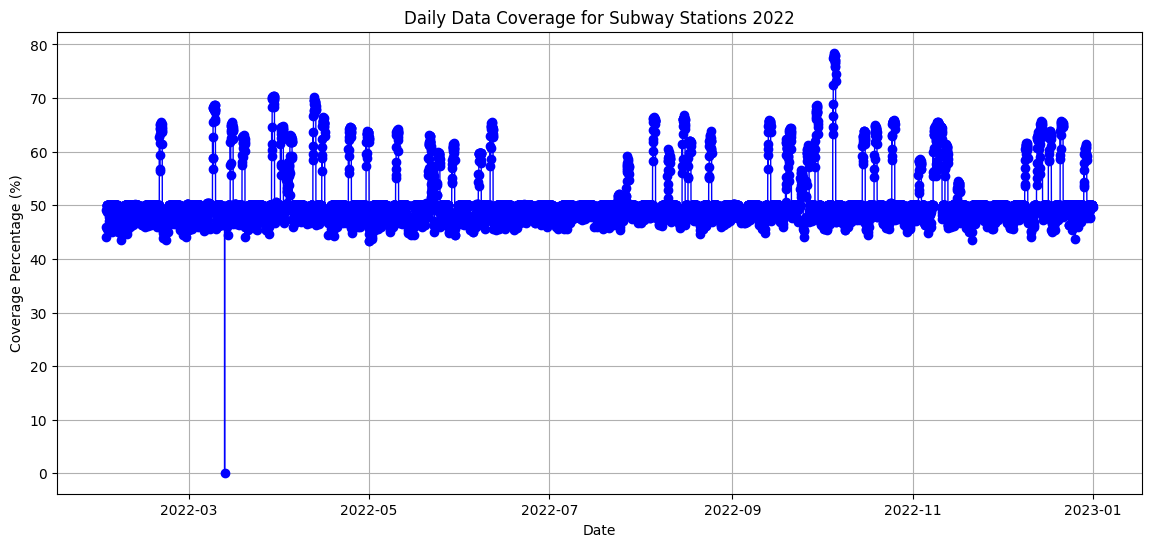

In [13]:
# Convert datetime column to actual datetime format for easier plotting
date_coverage_df_22['datetime'] = pd.to_datetime(date_coverage_df_22['datetime'])

# Plot
plt.figure(figsize=(14, 6))
plt.plot(date_coverage_df_22['datetime'], date_coverage_df_22['coverage_percentage'], color='b', marker='o', linestyle='-', linewidth=1)
plt.title('Daily Data Coverage for Subway Stations 2022')
plt.xlabel('Date')
plt.ylabel('Coverage Percentage (%)')
plt.grid(True)
plt.show()


### EDA: Explore potential stations where overlap of stations/times might be more significant using heatmap.

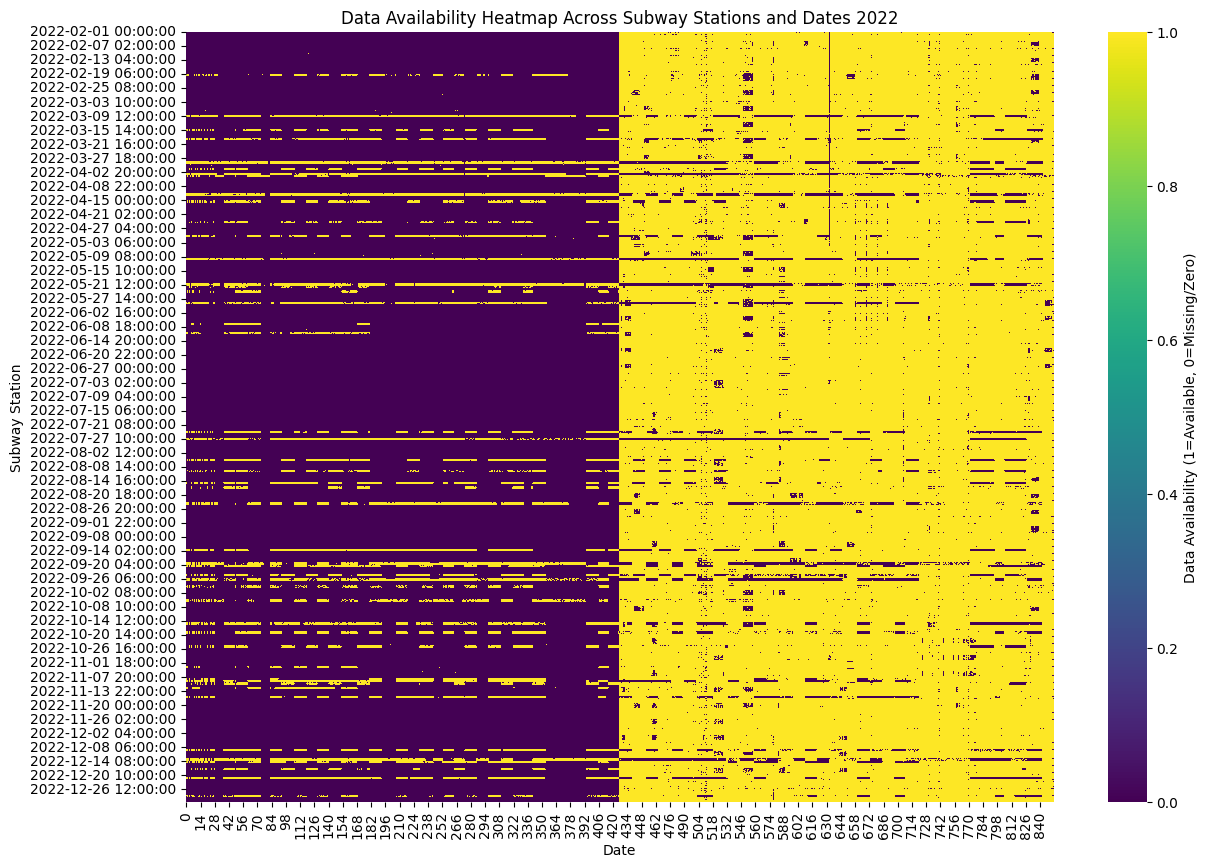

In [14]:
# Sum non-zero data across all stations for each date (columns)
data_overlap_matrix_22 = non_zero_data_22.T  # Transpose for heatmap (dates on x-axis, stations on y-axis)

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(data_overlap_matrix_22, cmap='viridis', cbar_kws={'label': 'Data Availability (1=Available, 0=Missing/Zero)'})
plt.title('Data Availability Heatmap Across Subway Stations and Dates 2022')
plt.xlabel('Date')
plt.ylabel('Subway Station')
plt.show()


### EDA: Explore completeness of data for all stations.

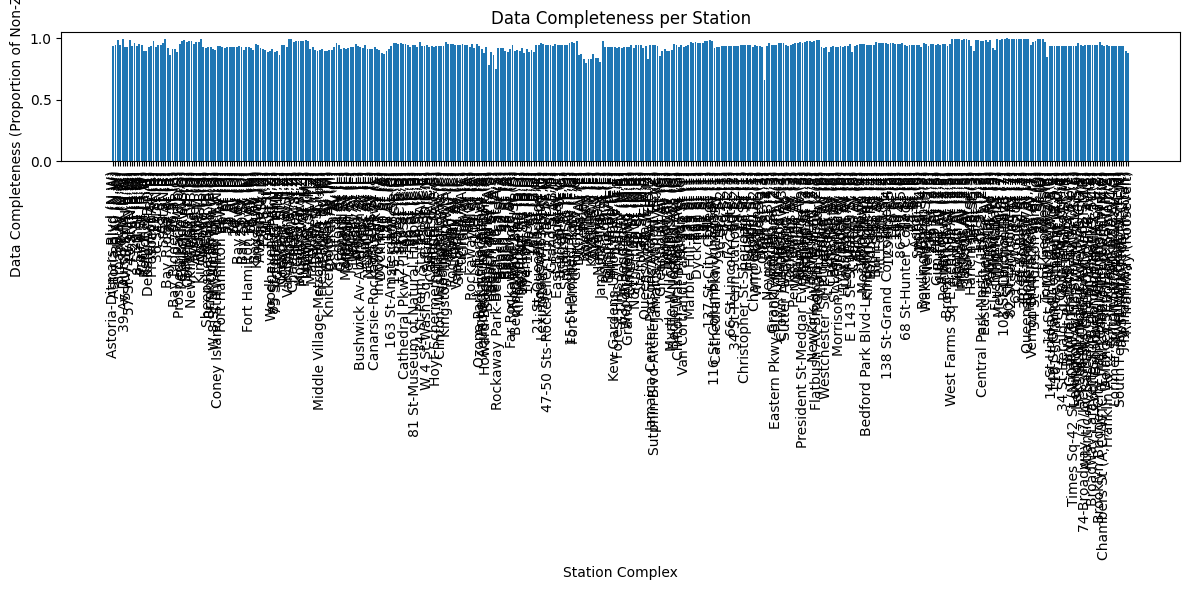

In [15]:
# Extract only the columns with the timestamp data for analysis
date_columns_22 = df_summed_22.columns[5:]  # assuming first 5 columns are non-date metadata

# Calculate completeness as the proportion of non-zero values for each station
df_summed_22['completeness'] = df_summed_22[date_columns_22].astype(bool).sum(axis=1) / len(date_columns_22)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(df_summed_22['station_complex'], df_summed_22['completeness'])
plt.xticks(rotation=90)
plt.xlabel('Station Complex')
plt.ylabel('Data Completeness (Proportion of Non-Zero Values)')
plt.title('Data Completeness per Station')
plt.tight_layout()
plt.show()


### EDA: Explore distribution of completeness, box-plot.

In [16]:
df_summed_22['completeness'].describe()


count    854.000000
mean       0.508948
std        0.430561
min        0.002869
25%        0.090475
50%        0.703031
75%        0.940213
max        0.997380
Name: completeness, dtype: float64

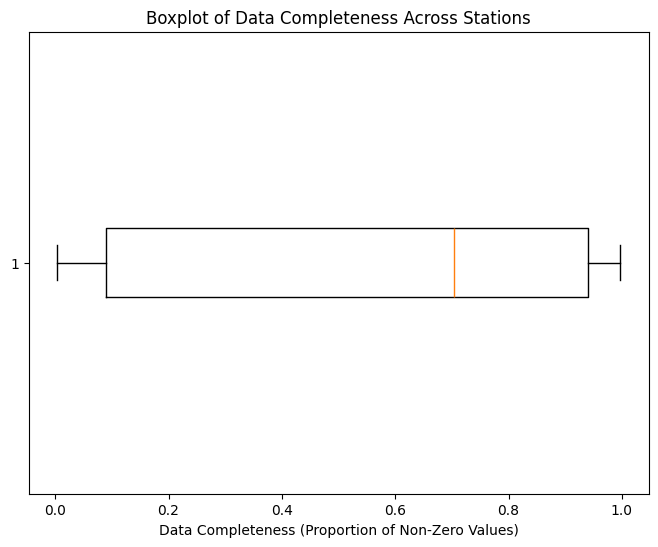

In [17]:
plt.figure(figsize=(8, 6))
plt.boxplot(df_summed_22['completeness'], vert=False)
plt.xlabel('Data Completeness (Proportion of Non-Zero Values)')
plt.title('Boxplot of Data Completeness Across Stations')
plt.show()


### EDA: Identify station overlap in 2022-23 data that meet thresholds of 90% completeness (non-NaN and non-zero values)

In [18]:
# Pivot the table to create wide format with `transit_timestamp` as columns
wide_data_23 = hourly_ridership_23.pivot(
    index=['station_complex_id', 'station_complex', 'borough', 'latitude', 'longitude'],
    columns='transit_timestamp',
    values='ridership'
).reset_index()

# Flatten the column hierarchy created by pivot
wide_data_23.columns.name = None  # Remove the column name
wide_data_23.columns = [f"{col}" for col in wide_data_23.columns]
display(wide_data_23)


,station_complex_id,station_complex,borough,latitude,longitude,2023-01-01 00:00:00,2023-01-01 01:00:00,2023-01-01 02:00:00,2023-01-01 03:00:00,2023-01-01 04:00:00,...,2023-12-31 14:00:00,2023-12-31 15:00:00,2023-12-31 16:00:00,2023-12-31 17:00:00,2023-12-31 18:00:00,2023-12-31 19:00:00,2023-12-31 20:00:00,2023-12-31 21:00:00,2023-12-31 22:00:00,2023-12-31 23:00:00
0,1,"Astoria-Ditmars Blvd (N,W)",Queens,40.775036,-73.912030,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"Astoria Blvd (N,W)",Queens,40.770260,-73.917850,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,"30 Av (N,W)",Queens,40.766780,-73.921480,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,"Broadway (N,W)",Queens,40.761820,-73.925510,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,"36 Av (N,W)",Queens,40.756805,-73.929570,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,97,"Myrtle Av (M,J,Z)",Brooklyn,40.697210,-73.935650,120.0,189.0,213.0,124.0,57.0,...,337.0,303.0,282.0,301.0,289.0,341.0,265.0,338.0,207.0,122.0
967,98,"Flushing Av (M,J)",Brooklyn,40.700260,-73.941124,54.0,55.0,44.0,23.0,22.0,...,173.0,186.0,213.0,182.0,184.0,152.0,149.0,119.0,102.0,39.0
968,99,"Lorimer St (M,J)",Brooklyn,40.703870,-73.947410,15.0,60.0,62.0,24.0,12.0,...,104.0,115.0,106.0,99.0,88.0,92.0,79.0,92.0,51.0,27.0
969,TRAM1,RI Tramway (Manhattan),Manhattan,40.761337,-73.964160,37.0,62.0,39.0,2.0,NaN,...,580.0,685.0,597.0,447.0,319.0,286.0,270.0,149.0,141.0,111.0


In [19]:
df_summed_23 = wide_data_23.groupby('station_complex_id', as_index=False).agg({
    'station_complex': 'first',
    'borough': 'first',
    'latitude': 'first',
    'longitude': 'first',
    **{col: 'sum' for col in wide_data_23.columns if col not in ['station_complex_id', 'station_complex', 'borough', 'latitude', 'longitude']}
})

# Display the result
display(df_summed_23)


,station_complex_id,station_complex,borough,latitude,longitude,2023-01-01 00:00:00,2023-01-01 01:00:00,2023-01-01 02:00:00,2023-01-01 03:00:00,2023-01-01 04:00:00,...,2023-12-31 14:00:00,2023-12-31 15:00:00,2023-12-31 16:00:00,2023-12-31 17:00:00,2023-12-31 18:00:00,2023-12-31 19:00:00,2023-12-31 20:00:00,2023-12-31 21:00:00,2023-12-31 22:00:00,2023-12-31 23:00:00
0,1,"Astoria-Ditmars Blvd (N,W)",Queens,40.775036,-73.912030,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,"Astoria Blvd (N,W)",Queens,40.770260,-73.917850,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,"30 Av (N,W)",Queens,40.766780,-73.921480,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,"Broadway (N,W)",Queens,40.761820,-73.925510,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,"36 Av (N,W)",Queens,40.756805,-73.929570,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,97,"Myrtle Av (M,J,Z)",Brooklyn,40.697210,-73.935650,120.0,189.0,213.0,124.0,57.0,...,337.0,303.0,282.0,301.0,289.0,341.0,265.0,338.0,207.0,122.0
849,98,"Flushing Av (M,J)",Brooklyn,40.700260,-73.941124,54.0,55.0,44.0,23.0,22.0,...,173.0,186.0,213.0,182.0,184.0,152.0,149.0,119.0,102.0,39.0
850,99,"Lorimer St (M,J)",Brooklyn,40.703870,-73.947410,15.0,60.0,62.0,24.0,12.0,...,104.0,115.0,106.0,99.0,88.0,92.0,79.0,92.0,51.0,27.0
851,TRAM1,RI Tramway (Manhattan),Manhattan,40.761337,-73.964160,37.0,62.0,39.0,2.0,0.0,...,580.0,685.0,597.0,447.0,319.0,286.0,270.0,149.0,141.0,111.0


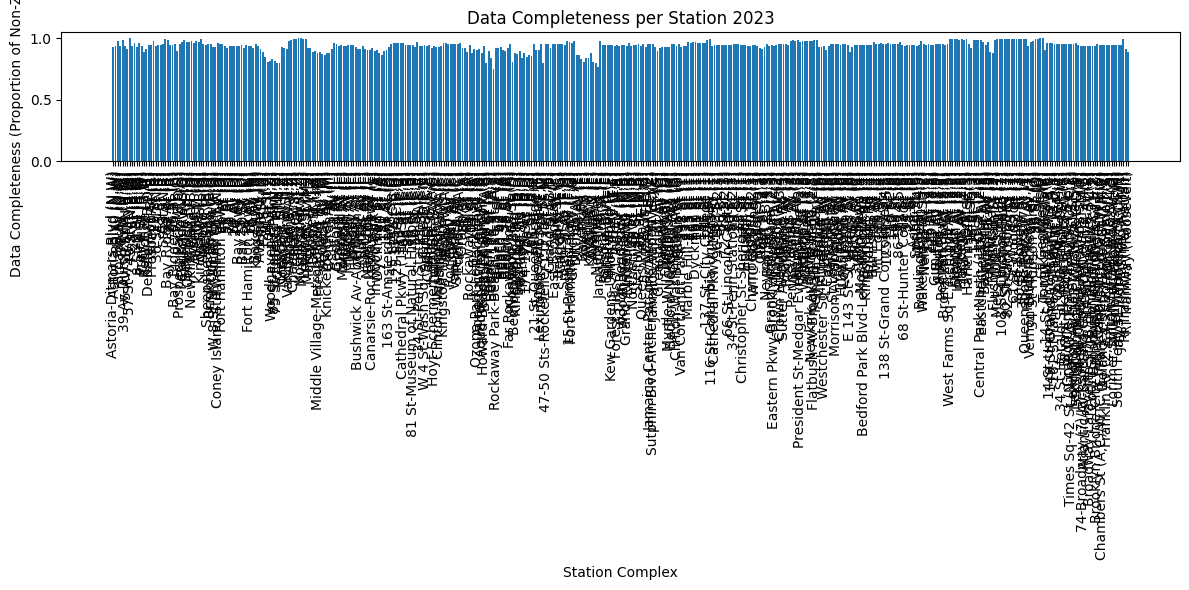

In [20]:
# Use only columns with the timestamp data for analysis
date_columns_23 = df_summed_23.columns[5:]  # assuming first 5 columns are non-date metadata

# Calculate completeness as the proportion of non-zero values for each station
df_summed_23['completeness'] = df_summed_23[date_columns_23].astype(bool).sum(axis=1) / len(date_columns_23)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(df_summed_23['station_complex'], df_summed_23['completeness'])
plt.xticks(rotation=90)
plt.xlabel('Station Complex')
plt.ylabel('Data Completeness (Proportion of Non-Zero Values)')
plt.title('Data Completeness per Station 2023')
plt.tight_layout()
plt.show()


In [21]:
df_summed_23['completeness'].describe()


count    853.000000
mean       0.514519
std        0.429345
min        0.000343
25%        0.096244
50%        0.767896
75%        0.947711
max        1.000000
Name: completeness, dtype: float64

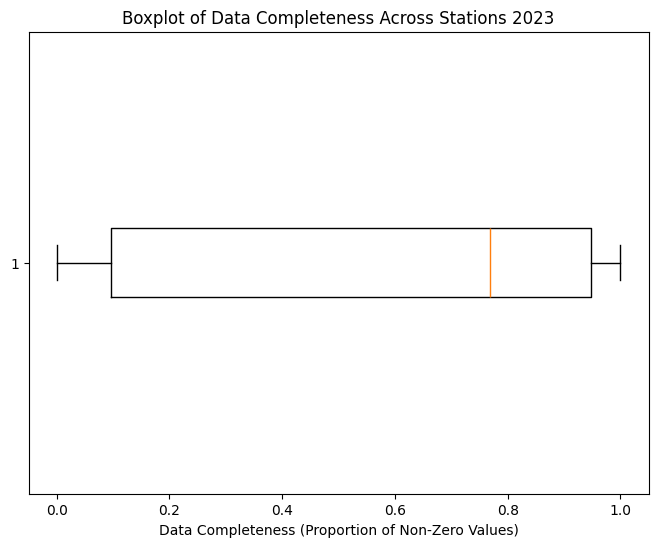

In [22]:
plt.figure(figsize=(8, 6))
plt.boxplot(df_summed_23['completeness'], vert=False)
plt.xlabel('Data Completeness (Proportion of Non-Zero Values)')
plt.title('Boxplot of Data Completeness Across Stations 2023')
plt.show()


In [23]:
stations_90_complete_22 = df_summed_22[df_summed_22['completeness'] >= 0.9]
stations_90_complete_23 = df_summed_23[df_summed_23['completeness'] >= 0.9]

# Get the sets of station_complex_id from both DataFrames
ids_22_90 = set(stations_90_complete_22['station_complex_id'])
ids_23_90 = set(stations_90_complete_23['station_complex_id'])

# Find the intersection of the two sets (shared IDs)
shared_ids_90 = ids_22_90.intersection(ids_23_90)
shared_ids_90 = sorted(shared_ids_90)

print(f'{len(shared_ids_90)} stations with overlap between 2022 and 2023 with 90% completeness', shared_ids_90)


361 stations with overlap between 2022 and 2023 with 90% completeness ['1', '10', '100', '101', '118', '119', '120', '122', '123', '124', '125', '126', '127', '129', '13', '130', '131', '133', '134', '135', '136', '137', '138', '14', '143', '147', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '162', '164', '165', '167', '168', '169', '17', '173', '175', '176', '177', '179', '180', '181', '182', '183', '185', '186', '187', '188', '189', '190', '192', '194', '195', '196', '198', '2', '203', '204', '205', '208', '209', '220', '221', '222', '223', '225', '228', '231', '232', '234', '235', '236', '237', '238', '240', '241', '242', '243', '254', '255', '256', '257', '258', '259', '26', '260', '261', '262', '263', '264', '265', '266', '268', '269', '270', '271', '272', '273', '277', '278', '279', '28', '280', '284', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '3', '30', '300', '301', '303', '304', '305', '306'

In [24]:
# Create a base map centered around the average latitude and longitude
m = folium.Map(location=[df_summed_22['latitude'].mean(), df_summed_22['longitude'].mean()], zoom_start=11)

# Create a color scale using a linear colormap
colormap = branca.colormap.LinearColormap(colors=['yellow', 'blue'], vmin=0, vmax=1)
colormap.caption = 'Data Completeness (0-1)'
m.add_child(colormap)

# Add markers to the map
for _, row in df_summed_22.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=5,  # You can adjust this size based on completeness if desired
        color=colormap(row['completeness']),
        fill=True,
        fill_color=colormap(row['completeness']),
        fill_opacity=0.7,
        popup=folium.Popup(f"{row['station_complex']}<br>Completeness: {row['completeness']:.2f}", parse_html=True),
    ).add_to(m)

display(m)


## Impute missing values to finish pre-processing for time-series analysis

In [25]:
# Load df_filled_22 and df_filled_23 for further analysis
df_filled_22 = pd.read_pickle(r'D:\capstone_F24\data\Cleaned_data\df_filled_22.pkl')
df_filled_23 = pd.read_pickle(r'D:\capstone_F24\data\Cleaned_data\df_filled_23.pkl')



### <span style="color:yellow"> NOTE: Do not run this section unless df_filled_22 and df_filled_23 are either unable to be located or loaded.</span>

In [26]:
'''def impute_missing_data(df, station_ids):
    """
    Impute missing hourly data for specified stations based on the mean of the rest of the station's data
    for that hour on all other days.
    
    Parameters:
    - df: DataFrame containing hourly data with station_complex_id as one of the columns.
    - station_ids: List of station_complex_id's to impute.
    
    Returns:
    - DataFrame with missing values imputed.
    """
    
    # Filter DataFrame for the specified station IDs
    df_filtered = df[df['station_complex_id'].isin(station_ids)].copy()
    
    # Melt the DataFrame to long format for easier time handling
    df_melted = df_filtered.melt(id_vars=['station_complex_id', 'station_complex', 'borough', 'latitude', 'longitude'],
                                  var_name='timestamp', value_name='count')

    # Convert timestamp column to datetime
    df_melted['timestamp'] = pd.to_datetime(df_melted['timestamp'], errors='coerce')

    # Set timestamp as index
    df_melted.set_index('timestamp', inplace=True)

    # Create a new DataFrame to hold the filled data
    df_filled = df_melted.copy()

    for station_id in station_ids:
        # Get the station's data
        station_data = df_filled[df_filled['station_complex_id'] == station_id]
        
        # Group by hour and calculate mean for that hour
        hourly_mean = station_data.groupby(station_data.index.hour)['count'].mean()

        # Iterate over each row in the station's data
        for index, row in station_data.iterrows():
            if pd.isna(row['count']):
                # If the count is missing, fill it with the mean of that hour
                hour = index.hour
                df_filled.loc[index, 'count'] = hourly_mean[hour]

    # Pivot back to wide format
    df_final = df_filled.reset_index().pivot(index='station_complex_id', columns='timestamp', values='count')
    
    # Restore the non-time columns
    for col in ['station_complex', 'borough', 'latitude', 'longitude']:
        df_final[col] = df_filtered[df_filtered['station_complex_id'].isin(station_ids)][col].values[0]

    return df_final
    

# Get the intersection of station IDs from both years
stations_90_complete_22 = df_summed_22[df_summed_22['completeness'] >= 0.9]['station_complex_id'].tolist()
stations_90_complete_23 = df_summed_23[df_summed_23['completeness'] >= 0.9]['station_complex_id'].tolist()
stations_to_impute = set(stations_90_complete_22) & set(stations_90_complete_23)

# Impute missing data for both years
df_filled_22 = impute_missing_data(df_summed_22, stations_to_impute)
df_filled_23 = impute_missing_data(df_summed_23, stations_to_impute)
'''

'def impute_missing_data(df, station_ids):\n    """\n    Impute missing hourly data for specified stations based on the mean of the rest of the station\'s data\n    for that hour on all other days.\n    \n    Parameters:\n    - df: DataFrame containing hourly data with station_complex_id as one of the columns.\n    - station_ids: List of station_complex_id\'s to impute.\n    \n    Returns:\n    - DataFrame with missing values imputed.\n    """\n    \n    # Filter DataFrame for the specified station IDs\n    df_filtered = df[df[\'station_complex_id\'].isin(station_ids)].copy()\n    \n    # Melt the DataFrame to long format for easier time handling\n    df_melted = df_filtered.melt(id_vars=[\'station_complex_id\', \'station_complex\', \'borough\', \'latitude\', \'longitude\'],\n                                  var_name=\'timestamp\', value_name=\'count\')\n\n    # Convert timestamp column to datetime\n    df_melted[\'timestamp\'] = pd.to_datetime(df_melted[\'timestamp\'], errors=\'coerc

In [28]:
'''
display(df_filled_23)
'''


'\ndisplay(df_filled_23)\n'

In [30]:
'''
# Select only datetime columns
datetime_cols = df_filled_22.columns[df_filled_22.columns.to_series().apply(lambda x: pd.to_datetime(x, errors='coerce')).notna()]
df_filled_22 = df_filled_22[datetime_cols]

# If you want to keep 'station_complex_id' as index, you don't need to reset the index.
display(df_filled_22)
'''

"\n# Select only datetime columns\ndatetime_cols = df_filled_22.columns[df_filled_22.columns.to_series().apply(lambda x: pd.to_datetime(x, errors='coerce')).notna()]\ndf_filled_22 = df_filled_22[datetime_cols]\n\n# If you want to keep 'station_complex_id' as index, you don't need to reset the index.\ndisplay(df_filled_22)\n"

In [31]:
'''# Select only datetime columns to drop NaT column
datetime_cols = df_filled_23.columns[df_filled_23.columns.to_series().apply(lambda x: pd.to_datetime(x, errors='coerce')).notna()]
df_filled_23 = df_filled_23[datetime_cols]

display(df_filled_23)
'''

"# Select only datetime columns to drop NaT column\ndatetime_cols = df_filled_23.columns[df_filled_23.columns.to_series().apply(lambda x: pd.to_datetime(x, errors='coerce')).notna()]\ndf_filled_23 = df_filled_23[datetime_cols]\n\ndisplay(df_filled_23)\n"

In [32]:
'''#Save clean files for LSTM preparation
df_filled_22.to_pickle(r"D:\capstone_F24\data\Cleaned_data\df_filled_22.pkl")
df_filled_23.to_pickle(r"D:\capstone_F24\data\Cleaned_data\df_filled_23.pkl")
'''

'#Save clean files for LSTM preparation\ndf_filled_22.to_pickle(r"D:\\capstone_F24\\data\\Cleaned_data\\df_filled_22.pkl")\ndf_filled_23.to_pickle(r"D:\\capstone_F24\\data\\Cleaned_data\\df_filled_23.pkl")\n'

In [33]:
'''# Filter the DataFrame for the specific station ID
station_id = '300'
station_data = df_filled_22.loc[station_id]

# Transpose the data for plotting
station_data_transposed = station_data.transpose()

# Set the datetime index
station_data_transposed.index = pd.to_datetime(station_data_transposed.index)

february_data = station_data_transposed[station_data_transposed.index.month == 2]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(february_data.index, february_data.values, marker='o', color='blue')
plt.title(f'Hourly Ridership for Station ID {station_id} in February')
plt.xlabel('Date and Time')
plt.ylabel('Ridership')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
'''

"# Filter the DataFrame for the specific station ID\nstation_id = '300'\nstation_data = df_filled_22.loc[station_id]\n\n# Transpose the data for plotting\nstation_data_transposed = station_data.transpose()\n\n# Set the datetime index\nstation_data_transposed.index = pd.to_datetime(station_data_transposed.index)\n\nfebruary_data = station_data_transposed[station_data_transposed.index.month == 2]\n\n# Plotting\nplt.figure(figsize=(12, 6))\nplt.plot(february_data.index, february_data.values, marker='o', color='blue')\nplt.title(f'Hourly Ridership for Station ID {station_id} in February')\nplt.xlabel('Date and Time')\nplt.ylabel('Ridership')\nplt.xticks(rotation=45)\nplt.grid()\nplt.tight_layout()\nplt.show()\n"

In [34]:
'''def drop_date_range_columns(df):
    """
    Drop columns with dates from 2023-01-01 00:00:00 to 2023-01-31 23:00:00
    
    Args:
        df (pd.DataFrame): Input DataFrame with datetime columns
        
    Returns:
        pd.DataFrame: DataFrame with specified date range columns dropped
    """
    # Create start and end dates
    start_date = pd.to_datetime('2023-01-01 00:00:00')
    end_date = pd.to_datetime('2023-01-31 23:00:00')
    
    # Get list of datetime columns
    datetime_cols = []
    for col in df.columns:
        try:
            date = pd.to_datetime(col)
            if start_date <= date <= end_date:
                datetime_cols.append(col)
        except (ValueError, TypeError):
            continue
    
    # Drop the columns and return new dataframe
    return df.drop(columns=datetime_cols)

df_filled_23 = drop_date_range_columns(df_filled_23)
'''

'def drop_date_range_columns(df):\n    """\n    Drop columns with dates from 2023-01-01 00:00:00 to 2023-01-31 23:00:00\n    \n    Args:\n        df (pd.DataFrame): Input DataFrame with datetime columns\n        \n    Returns:\n        pd.DataFrame: DataFrame with specified date range columns dropped\n    """\n    # Create start and end dates\n    start_date = pd.to_datetime(\'2023-01-01 00:00:00\')\n    end_date = pd.to_datetime(\'2023-01-31 23:00:00\')\n    \n    # Get list of datetime columns\n    datetime_cols = []\n    for col in df.columns:\n        try:\n            date = pd.to_datetime(col)\n            if start_date <= date <= end_date:\n                datetime_cols.append(col)\n        except (ValueError, TypeError):\n            continue\n    \n    # Drop the columns and return new dataframe\n    return df.drop(columns=datetime_cols)\n\ndf_filled_23 = drop_date_range_columns(df_filled_23)\n'

In [35]:
'''# Check if the column for 2023-03-12 02:00:00 is missing
missing_column = pd.to_datetime('2023-03-12 02:00:00')

# If the column is missing, add it
if missing_column not in df_filled_23.columns:
    # Impute the average for each row
    df_filled_23[missing_column] = df_filled_23.mean(axis=1)

# Display the updated DataFrame with the new column
df_filled_23.head()
'''

"# Check if the column for 2023-03-12 02:00:00 is missing\nmissing_column = pd.to_datetime('2023-03-12 02:00:00')\n\n# If the column is missing, add it\nif missing_column not in df_filled_23.columns:\n    # Impute the average for each row\n    df_filled_23[missing_column] = df_filled_23.mean(axis=1)\n\n# Display the updated DataFrame with the new column\ndf_filled_23.head()\n"

In [36]:
'''#Save updated version with filled values and clean
df_filled_23 = df_filled_23.to_pickle(r'D:\capstone_F24\data\Cleaned_data\df_filled_23.pkl')
'''

"#Save updated version with filled values and clean\ndf_filled_23 = df_filled_23.to_pickle(r'D:\\capstone_F24\\data\\Cleaned_data\\df_filled_23.pkl')\n"

## LSTM Time Series Modeling and Forecast Hourly Predictions for 2023

### <span style="color:yellow"> NOTE: Do not run this section unless metrics_LSTM and predictions_2023_LSTM are either unable to be located or loaded.</span>

In [37]:
'''# Define SMAPE
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100
'''

'# Define SMAPE\ndef smape(y_true, y_pred):\n    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100\n'

In [38]:
'''# Prepare containers
metrics = []
pred_23 = pd.DataFrame(index=df_filled_23.index, columns=df_filled_23.columns)

# Normalize data
scaler = MinMaxScaler()

# Process in batches of 10
batch_size = 10
station_ids = df_filled_22.index
num_stations = len(station_ids)
'''

'# Prepare containers\nmetrics = []\npred_23 = pd.DataFrame(index=df_filled_23.index, columns=df_filled_23.columns)\n\n# Normalize data\nscaler = MinMaxScaler()\n\n# Process in batches of 10\nbatch_size = 10\nstation_ids = df_filled_22.index\nnum_stations = len(station_ids)\n'

In [39]:
'''
for batch_start in range(0, num_stations, batch_size):
    batch_end = min(batch_start + batch_size, num_stations)
    batch_ids = station_ids[batch_start:batch_end]
    
    percent_complete = (batch_end / num_stations) * 100
    print(f"Processing stations {batch_start + 1} to {batch_end} of {num_stations} ({percent_complete:.2f}% complete)")
    
    
    for station_id in batch_ids:
        try:
            # Extract data
            train_data = df_filled_22.loc[station_id].values
            test_data = df_filled_23.loc[station_id].values
            
            # Normalize
            train_data_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
            test_data_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()
            
            # Prepare sequences for LSTM (24-hour cycle)
            sequence_length = 24
            def create_sequences(data):
                X, y = [], []
                for i in range(len(data) - sequence_length):
                    X.append(data[i:i + sequence_length])
                    y.append(data[i + sequence_length])
                return np.array(X), np.array(y)
            
            X_train, y_train = create_sequences(train_data_scaled)
            X_test, y_test = create_sequences(test_data_scaled)
            
            # Reshape for LSTM (samples, time_steps, features)
            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
            X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
            
            # Build LSTM model
            model = Sequential([
                LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
                Dense(1)
            ])
            model.compile(optimizer='adam', loss='mae')
            
            # Train model
            es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
            model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, callbacks=[es])
            
            # Predict
            y_pred_scaled = model.predict(X_test, verbose=0)
            y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
            
            # Compute metrics
            y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
            mae = mean_absolute_error(y_test_actual, y_pred)
            smape_val = smape(y_test_actual, y_pred)
            
            metrics.append({
                'station_complex_id': station_id,
                'mae': mae,
                'smape': smape_val
            })
            
            # Save predictions
            # Save predictions to pred_23
            pred_23.iloc[station_ids.get_loc(station_id), sequence_length:] = y_pred
            
            # Print progress for each row
            print(f"Station {station_id} - First Predicted: {y_pred[0]:.2f}, First Actual: {y_test_actual[0]:.2f}")
            
        except Exception as e:
            print(f"Error processing station {station_id}: {e}")

# Save metrics
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("metrics_LSTM.csv", index=False)

# Save predictions
pred_23.to_csv("predictions_2023_LSTM.csv")

print("Processing complete.")
'''

'\nfor batch_start in range(0, num_stations, batch_size):\n    batch_end = min(batch_start + batch_size, num_stations)\n    batch_ids = station_ids[batch_start:batch_end]\n    \n    percent_complete = (batch_end / num_stations) * 100\n    print(f"Processing stations {batch_start + 1} to {batch_end} of {num_stations} ({percent_complete:.2f}% complete)")\n    \n    \n    for station_id in batch_ids:\n        try:\n            # Extract data\n            train_data = df_filled_22.loc[station_id].values\n            test_data = df_filled_23.loc[station_id].values\n            \n            # Normalize\n            train_data_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()\n            test_data_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()\n            \n            # Prepare sequences for LSTM (24-hour cycle)\n            sequence_length = 24\n            def create_sequences(data):\n                X, y = [], []\n                for i in range(len(data)

## Loading and viewing prepared metrics and prediction data from LSTM model

In [41]:
metrics_df = pd.read_csv('metrics_LSTM.csv')

display(metrics_df)


,station_complex_id,mae,smape
0,1,49.620950,44.602812
1,1,53.187994,38.118923
2,10,98.286169,39.630500
3,100,13.771899,49.087639
4,101,50.727295,42.301411
...,...,...,...
357,95,21.216283,21.930531
358,96,20.938857,22.228978
359,97,46.286339,22.333906
360,98,29.048714,23.326803


In [42]:
pred_23 = pd.read_csv('predictions_2023_LSTM.csv')

display(pred_23)


,station_complex_id,2023-02-01 00:00:00,2023-02-01 01:00:00,2023-02-01 02:00:00,2023-02-01 03:00:00,2023-02-01 04:00:00,2023-02-01 05:00:00,2023-02-01 06:00:00,2023-02-01 07:00:00,2023-02-01 08:00:00,...,2023-12-31 14:00:00,2023-12-31 15:00:00,2023-12-31 16:00:00,2023-12-31 17:00:00,2023-12-31 18:00:00,2023-12-31 19:00:00,2023-12-31 20:00:00,2023-12-31 21:00:00,2023-12-31 22:00:00,2023-12-31 23:00:00
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,368.007812,387.721741,340.160645,342.505005,360.782806,368.168793,283.338745,275.484100,252.844162,193.141098
1,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.506256,94.267654,100.025291,113.206673,116.355698,127.655991,121.788689,120.540894,103.885345,64.015182
2,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51.751060,70.668304,58.037613,53.865177,47.962364,62.775818,61.037983,70.727318,59.069241,39.708309
3,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,285.789642,360.259583,349.375000,349.556671,333.420349,264.777893,289.547577,261.117889,221.719513,167.198029
4,118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,191.045364,235.889038,266.273254,287.816040,272.193726,307.205902,287.013916,288.322845,278.256287,266.677399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,206.760986,188.200546,190.297424,152.052673,142.832504,156.478409,157.645599,129.517548,109.835312,90.225037
357,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,173.499420,167.879028,149.683807,114.655594,121.541443,123.531746,154.509933,118.086830,99.317261,75.196892
358,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,331.007050,277.263641,245.481171,223.628479,232.348801,213.415466,239.033340,177.867386,221.147873,130.565018
359,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,189.063339,186.642303,200.269363,212.959717,181.329819,165.143921,134.125473,122.330414,96.647598,81.807953


### Merging Predictions, Metrics, and Station Attributes

In [43]:
# Reset index to include station_complex_id as a column
preds_long = pred_23.melt(
    id_vars=["station_complex_id"],  # Columns to keep as identifiers
    var_name="timestamp",           # Name for the 'wide' columns (timestamps)
    value_name="ridership"          # Name for the values in those columns
)

# Convert the timestamp column to a proper datetime type if necessary
preds_long["timestamp"] = pd.to_datetime(preds_long["timestamp"])

preds_long

,station_complex_id,timestamp,ridership
0,1,2023-02-01 00:00:00,NaN
1,10,2023-02-01 00:00:00,NaN
2,100,2023-02-01 00:00:00,NaN
3,101,2023-02-01 00:00:00,NaN
4,118,2023-02-01 00:00:00,NaN
...,...,...,...
2893771,95,2023-12-31 23:00:00,90.225037
2893772,96,2023-12-31 23:00:00,75.196892
2893773,97,2023-12-31 23:00:00,130.565018
2893774,98,2023-12-31 23:00:00,81.807953


In [44]:
preds_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893776 entries, 0 to 2893775
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   station_complex_id  int64         
 1   timestamp           datetime64[ns]
 2   ridership           float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 66.2 MB


In [45]:
preds_long['station_complex_id'] = preds_long['station_complex_id'].astype(str)

In [46]:
# Reset index to include station_complex_id as a column
actual_long = df_filled_23.reset_index().melt(
    id_vars=["station_complex_id"],  # Columns to keep as identifiers
    var_name="timestamp",           # Name for the 'wide' columns (timestamps)
    value_name="ridership"          # Name for the values in those columns
)

# Convert the timestamp column to a proper datetime type if necessary
actual_long["timestamp"] = pd.to_datetime(actual_long["timestamp"])

actual_long

,station_complex_id,timestamp,ridership
0,1,2023-02-01 00:00:00,27.0
1,10,2023-02-01 00:00:00,167.0
2,100,2023-02-01 00:00:00,13.0
3,101,2023-02-01 00:00:00,59.0
4,118,2023-02-01 00:00:00,94.0
...,...,...,...
2893771,95,2023-12-31 23:00:00,55.0
2893772,96,2023-12-31 23:00:00,51.0
2893773,97,2023-12-31 23:00:00,122.0
2893774,98,2023-12-31 23:00:00,39.0


In [47]:
actual_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893776 entries, 0 to 2893775
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   station_complex_id  object        
 1   timestamp           datetime64[ns]
 2   ridership           float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 66.2+ MB


In [48]:
# Rename the 'ridership' column in preds_long to 'predicted'
preds_long = preds_long.rename(columns={"ridership": "predicted"})

# Rename the 'ridership' column in actual_long to 'actual'
actual_long = actual_long.rename(columns={"ridership": "actual"})

# Merge preds_long with actual_long on 'station_complex_id' and 'timestamp'
pred_vs_actual = actual_long.merge(
    preds_long[["station_complex_id", "timestamp", "predicted"]],  # Select relevant columns from preds_long
    on=["station_complex_id", "timestamp"],                       # Merge on these columns
    how="inner"                                                   # Use inner join to keep only matching rows
)

pred_vs_actual

,station_complex_id,timestamp,actual,predicted
0,1,2023-02-01 00:00:00,27.0,NaN
1,10,2023-02-01 00:00:00,167.0,NaN
2,100,2023-02-01 00:00:00,13.0,NaN
3,101,2023-02-01 00:00:00,59.0,NaN
4,118,2023-02-01 00:00:00,94.0,NaN
...,...,...,...,...
2893771,95,2023-12-31 23:00:00,55.0,90.225037
2893772,96,2023-12-31 23:00:00,51.0,75.196892
2893773,97,2023-12-31 23:00:00,122.0,130.565018
2893774,98,2023-12-31 23:00:00,39.0,81.807953


In [49]:
# Reset index to include station_complex_id as a column
actual_22_long = df_filled_22.reset_index().melt(
    id_vars=["station_complex_id"],  # Columns to keep as identifiers
    var_name="timestamp",           # Name for the 'wide' columns (timestamps)
    value_name="ridership"          # Name for the values in those columns
)

# Convert the timestamp column to a proper datetime type if necessary
actual_22_long["timestamp"] = pd.to_datetime(actual_22_long["timestamp"])

actual_22_long

,station_complex_id,timestamp,ridership
0,1,2022-02-01 00:00:00,17.0
1,10,2022-02-01 00:00:00,100.0
2,100,2022-02-01 00:00:00,10.0
3,101,2022-02-01 00:00:00,26.0
4,118,2022-02-01 00:00:00,21.0
...,...,...,...
2893771,95,2022-12-31 23:00:00,62.0
2893772,96,2022-12-31 23:00:00,61.0
2893773,97,2022-12-31 23:00:00,83.0
2893774,98,2022-12-31 23:00:00,39.0


In [50]:
# Rename the 'ridership' column in actual_long to 'actual'
pred_vs_actual = pred_vs_actual.rename(columns={"actual": "actual_23", "predicted":"pred_23"})

pred_vs_actual

,station_complex_id,timestamp,actual_23,pred_23
0,1,2023-02-01 00:00:00,27.0,NaN
1,10,2023-02-01 00:00:00,167.0,NaN
2,100,2023-02-01 00:00:00,13.0,NaN
3,101,2023-02-01 00:00:00,59.0,NaN
4,118,2023-02-01 00:00:00,94.0,NaN
...,...,...,...,...
2893771,95,2023-12-31 23:00:00,55.0,90.225037
2893772,96,2023-12-31 23:00:00,51.0,75.196892
2893773,97,2023-12-31 23:00:00,122.0,130.565018
2893774,98,2023-12-31 23:00:00,39.0,81.807953


In [51]:
df_station_info = pd.read_csv(r"D:\capstone_F24\data\MTA_Subway_Stations_20241002.csv")

In [52]:
df_station_info

,GTFS Stop ID,Station ID,Complex ID,Division,Line,Stop Name,Borough,CBD,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Northbound,ADA Southbound,ADA Notes,Georeference
0,R01,1,1,BMT,Astoria,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,Last Stop,Manhattan,0,0,0,NaN,POINT (-73.912034 40.775036)
1,R03,2,2,BMT,Astoria,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,Astoria,Manhattan,1,1,1,NaN,POINT (-73.917843 40.770258)
2,R04,3,3,BMT,Astoria,30 Av,Q,False,N W,Elevated,40.766779,-73.921479,Astoria,Manhattan,0,0,0,NaN,POINT (-73.921479 40.766779)
3,R05,4,4,BMT,Astoria,Broadway,Q,False,N W,Elevated,40.761820,-73.925508,Astoria,Manhattan,0,0,0,NaN,POINT (-73.925508 40.76182)
4,R06,5,5,BMT,Astoria,36 Av,Q,False,N W,Elevated,40.756804,-73.929575,Astoria,Manhattan,0,0,0,NaN,POINT (-73.929575 40.756804)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,S15,517,517,SIR,Staten Island,Prince's Bay,SI,False,SIR,Open Cut,40.525507,-74.200064,Ferry,South Shore,0,0,0,NaN,POINT (-74.200064 40.525507)
492,S14,518,518,SIR,Staten Island,Pleasant Plains,SI,False,SIR,Embankment,40.522410,-74.217847,Ferry,South Shore,0,0,0,NaN,POINT (-74.217847 40.52241)
493,S13,519,519,SIR,Staten Island,Richmond Valley,SI,False,SIR,Open Cut,40.519631,-74.229141,Ferry,Tottenville,0,0,0,NaN,POINT (-74.229141 40.519631)
494,S09,522,522,SIR,Staten Island,Tottenville,SI,False,SIR,At Grade,40.512764,-74.251961,Ferry,Last Stop,1,1,1,NaN,POINT (-74.251961 40.512764)


In [59]:
# Change Complex ID to string in df_station_info to match in merged_df
df_station_info['Complex ID'] = df_station_info['Complex ID'].astype(str)

# Remove duplicates in df_station_info based on Complex ID
df_station_info_unique = df_station_info.drop_duplicates(subset=['Complex ID'])

# Select relevant columns from df_station_info
station_info_cols = ['Complex ID', 'Stop Name', 'Borough', 'Daytime Routes', 
                     'Structure', 'GTFS Latitude', 'GTFS Longitude']
df_station_info_selected = df_station_info_unique[station_info_cols]

# Perform the merge
merged_df = pred_vs_actual.merge(
    df_station_info_selected, 
    left_on='station_complex_id', 
    right_on='Complex ID', 
    how='left'
)

# Drop duplicate 'Complex ID' column if desired
merged_df = merged_df.drop(columns=['Complex ID'])

merged_df

,station_complex_id,timestamp,actual_23,pred_23,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude
0,1,2023-02-01 00:00:00,27.0,NaN,Astoria-Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034
1,10,2023-02-01 00:00:00,167.0,NaN,49 St,M,N R W,Subway,40.759901,-73.984139
2,100,2023-02-01 00:00:00,13.0,NaN,Hewes St,Bk,M J,Elevated,40.706870,-73.953431
3,101,2023-02-01 00:00:00,59.0,NaN,Marcy Av,Bk,M J Z,Elevated,40.708359,-73.957757
4,118,2023-02-01 00:00:00,94.0,NaN,3 Av,M,L,Subway,40.732849,-73.986122
...,...,...,...,...,...,...,...,...,...,...
2893771,95,2023-12-31 23:00:00,55.0,90.225037,Gates Av,Bk,J Z,Elevated,40.689630,-73.922270
2893772,96,2023-12-31 23:00:00,51.0,75.196892,Kosciuszko St,Bk,J,Elevated,40.693342,-73.928814
2893773,97,2023-12-31 23:00:00,122.0,130.565018,Myrtle Av,Bk,M J Z,Elevated,40.697207,-73.935657
2893774,98,2023-12-31 23:00:00,39.0,81.807953,Flushing Av,Bk,M J,Elevated,40.700260,-73.941126


In [60]:
# Rename 'GTFS Latitude' and 'GTFS Longitude' columns to 'lat' and 'long' respectively
merged_df.rename(columns={'GTFS Latitude': 'lat', 'GTFS Longitude': 'long', 'Stop Name': 'stop_name', 'Borough': 'borough','Structure': 'structure'}, inplace=True)

# Create proxy variable 'is_weekend' which determines if the timestamp is a weekend (1 for weekend, 0 for weekday)
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])  # Ensure timestamp is in datetime format
merged_df['is_weekend'] = merged_df['timestamp'].dt.weekday >= 5  # 5 and 6 represent Saturday and Sunday
merged_df['is_weekend'] = merged_df['is_weekend'].astype(int)  # Convert boolean to integer (1 for weekend, 0 for weekday)

# Create proxy variable 'day_of_week' which gets the day of the week as an integer (0=Monday, 6=Sunday)
merged_df['day_of_week'] = merged_df['timestamp'].dt.weekday

# Refactor 'Daytime Routes' column into a new column 'routes' which is a list of elements split by space
merged_df['routes'] = merged_df['Daytime Routes'].str.split()

# Add new column 'num_lines_serviced' which is the length of each list in the 'routes' column
merged_df['num_lines_serviced'] = merged_df['routes'].apply(len)
# Convert num_lines_serviced to integer, no values between whole nums
merged_df['num_lines_serviced'] = merged_df['num_lines_serviced'].astype(int)

# Drop the 'Daytime Routes' column
merged_df.drop(columns=['Daytime Routes'], inplace=True)

# Drop rows for 2023 predictions which have NaN values
merged_df = merged_df.dropna(subset=["pred_23"])

# Calculate difference column of predicted minus actual 
merged_df['diff_23'] = merged_df['actual_23'] - merged_df['pred_23']

# Rename the boroughs accordingly for viz
merged_df['borough'] = merged_df['borough'].replace({
    'Bk': 'Brooklyn',
    'M': 'Manhattan',
    'Q': 'Queens',
    'Bx': 'Bronx',
    'SI': 'Staten Island'
})


In [62]:
metrics_df['station_complex_id'] = metrics_df['station_complex_id'].astype(str)

In [63]:
#Merge on complex ID to include metrics of MAE and SMAPE per station
merged_df = merged_df.merge(metrics_df, on='station_complex_id', how='left')

In [65]:
merged_df.to_pickle('merged_df.pkl')

## Visualization - MAE and SMAPE Error Performance by Features of Station

In [88]:
def calculate_error_metrics(actual_series, pred_series):
    """
    Calculate error metrics for predictive models.

    Args:
        actual_series (pd.Series): Actual observed values
        pred_series (pd.Series): Predicted values

    Returns:
        dict: Dictionary containing Mean Absolute Error (MAE) and Symmetric Mean Absolute Percentage Error (SMAPE)
    """
    mae = np.mean(np.abs(actual_series - pred_series))
    smape = np.mean(np.abs(actual_series - pred_series) / 
                    ((np.abs(actual_series) + np.abs(pred_series)) / 2)) * 100
    
    return {
        'mae': mae,
        'smape': smape
    }

def prepare_error_metrics_by_feature(df):
    """
    Compute error metrics grouped by different features.

    Args:
        df (pd.DataFrame): Input DataFrame with prediction data

    Returns:
        dict: Grouped error metrics for various features
    """
    # Ensure timestamp is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Extract time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.day_name()
    df['month'] = df['timestamp'].dt.month_name()
    
    # Features to aggregate
    features_to_group = [
        'hour', 
        'day_of_week', 
        'month', 
        'borough', 
        'num_lines_serviced'
    ]
    
    # Compute grouped error metrics
    grouped_metrics = {}
    for feature in features_to_group:
        # Compute error metrics for each group
        grouped_errors = df.groupby(feature).apply(
            lambda x: pd.Series(calculate_error_metrics(x['actual_23'], x['pred_23']))
        ).reset_index()
        
        # Custom ordering for specific features
        if feature == 'day_of_week':
            day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            grouped_errors['day_of_week'] = pd.Categorical(grouped_errors['day_of_week'], categories=day_order, ordered=True)
            grouped_errors = grouped_errors.sort_values('day_of_week')
        
        elif feature == 'month':
            month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                           'July', 'August', 'September', 'October', 'November', 'December']
            grouped_errors['month'] = pd.Categorical(grouped_errors['month'], categories=month_order, ordered=True)
            grouped_errors = grouped_errors.sort_values('month')
        
        elif feature == 'num_lines_serviced':
            # Sort numerically if column is string type
            # Convert to numeric, handling any potential non-numeric values
            try:
                grouped_errors['num_lines_serviced'] = pd.to_numeric(grouped_errors['num_lines_serviced'], errors='coerce')
                grouped_errors = grouped_errors.sort_values('num_lines_serviced')
                # Convert back to string to maintain original type
                grouped_errors['num_lines_serviced'] = grouped_errors['num_lines_serviced'].astype(str)
            except Exception as e:
                print(f"Warning: Could not sort num_lines_serviced numerically. Error: {e}")
        
        grouped_metrics[feature] = grouped_errors
    
    return grouped_metrics

def create_interactive_error_dashboard(df):
    """
    Create an interactive Plotly dashboard for visualizing prediction error metrics.

    Args:
        df (pd.DataFrame): Input DataFrame with prediction data

    Returns:
        go.Figure: Interactive Plotly dashboard for error metrics
    """
    # Prepare error metrics
    error_metrics = prepare_error_metrics_by_feature(df)
    
    # Feature mapping with human-readable labels
    feature_mapping = {
        'Hour of Day': ('hour', error_metrics['hour']),
        'Day of Week': ('day_of_week', error_metrics['day_of_week']),
        'Month': ('month', error_metrics['month']),
        'Borough': ('borough', error_metrics['borough']),
        'Number of Lines Serviced': ('num_lines_serviced', error_metrics['num_lines_serviced'])
    }
    
    # Create figure
    fig = go.Figure()
    
    # Initial plot configuration
    initial_feature = 'Hour of Day'
    initial_feature_col, initial_data = feature_mapping[initial_feature]
    
    # Add initial bar trace
    fig.add_trace(
        go.Bar(
            x=initial_data[initial_feature_col], 
            y=initial_data['mae'], 
            name='Mean Absolute Error',
            marker_color='#FF6319'
        )
    )
    
    # Dropdown for feature selection
    feature_dropdown = []
    for key in feature_mapping.keys():
        feature_col, feature_data = feature_mapping[key]
        dropdown_item = {
            'label': key, 
            'method': 'update', 
            'args': [
                {
                    'x': [feature_data[feature_col]],
                    'y': [feature_data['mae']]
                },
                {
                    'xaxis.title.text': key  # Update x-axis title dynamically
                }
            ]
        }
        feature_dropdown.append(dropdown_item)
    
    # Metric dropdown
    metric_dropdown = [
        {
            'label': '(MAE) Mean Absolute Error', 
            'method': 'update', 
            'args': [
                {'y': [initial_data['mae']]},
                {}  # Empty dict for layout updates to maintain consistency
            ]
        },
        {
            'label': '(SMAPE) Symmetric Mean Absolute Percentage Error', 
            'method': 'update', 
            'args': [
                {'y': [initial_data['smape']]},
                {}  # Empty dict for layout updates to maintain consistency
            ]
        }
    ]
    
    # Update layout with professional styling and increased padding
    fig.update_layout(
        title={
            'text': '<b>NYC Subway Ridership 2023 - LSTM Prediction Error Metrics</b>',
            'font': {'size': 24, 'color': '#0039A6'},
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='Hour of Day',  # Initial x-axis title matches initial feature
        yaxis_title='Error Metric Value<br><i>MAE: # of Riders Error, SMAPE: % of Error</i>',
        font=dict(family='Arial', size=12),
        plot_bgcolor='rgba(240,240,240,0.95)',
        height=600,  # Increased figure height
        margin=dict(t=125,l=100),  # Increased top margin for more space between dropdowns and figure
        updatemenus=[
            # Feature selection dropdown
            dict(
                buttons=feature_dropdown,
                direction="down",
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.15,  # Increased y position for more padding
                yanchor="top"
            ),
            # Metric selection dropdown
            dict(
                buttons=metric_dropdown,
                direction="down",
                showactive=True,
                x=0.5,
                xanchor="left",
                y=1.15,  # Increased y position for more padding
                yanchor="top"
            )
        ]
    )
    
    # Styling the plot
    fig.update_traces(
        marker_line_color='rgb(8,48,107)',
        opacity=0.8
    )
    
    return fig

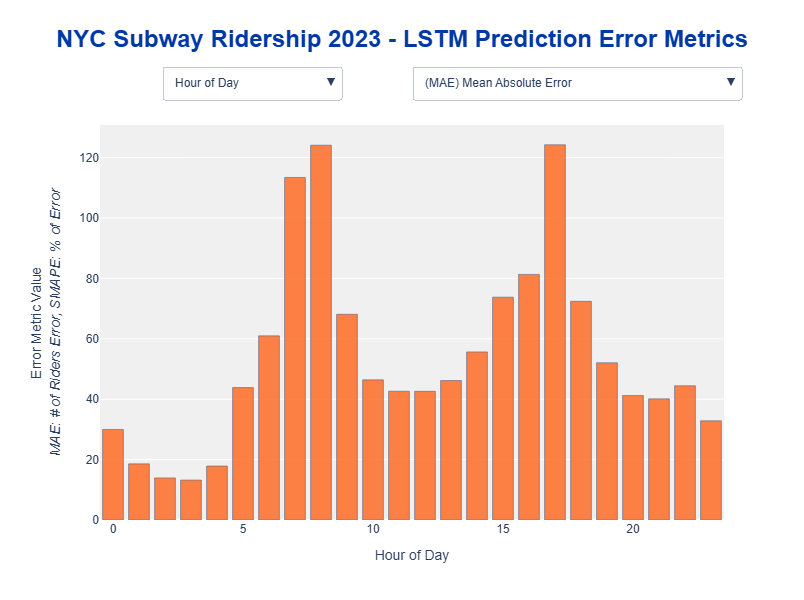

In [89]:
interactive_error_dashboard = create_interactive_error_dashboard(merged_df)
interactive_error_dashboard.show()

In [101]:
# Save the figure as an HTML file
pio.write_html(interactive_error_dashboard, file="ridership_error_by_features.html", full_html=True)

## Visualization - Top 10 Stations with Highest MAE and SMAPE Error Performance

In [99]:
def analyze_spatial_errors(error_df):
    """
    Analyze error metrics across spatial dimensions with enhanced hover data and custom colors
    
    Args:
        error_df (pd.DataFrame): DataFrame with computed error metrics
    
    Returns:
        dict: Dictionary of Plotly figures for spatial error analysis
    """
    # Top 10 Stations with Highest MAE
    top_mae_stations = error_df.nlargest(10, 'mae')
    fig_top_stations_mae = px.bar(
        top_mae_stations, 
        x='stop_name', 
        y='mae',
        title='Top 10 Stations with Highest Mean Absolute Error',
        labels={'stop_name': 'Station', 'mae': 'Mean Absolute Error'},
        hover_data={
            'stop_name': True, 
            'mae': ':.2f', 
            'borough': True, 
            'num_lines_serviced': True, 
            'structure': True
        },
        color_discrete_sequence=['#6CBE45']  # MTA light green color
    )
    fig_top_stations_mae.update_layout(
        height=600,
        title_x=0.5,
        title_font=dict(
            family='Arial',
            size=24,
            color='#0039A6',
            weight='bold'
        ),
        font=dict(
            family='Arial'
        ),
        xaxis_title='Station',
        yaxis_title='Mean Absolute Error',
        hoverlabel=dict(
            bgcolor='white',  # Set hover tooltip background to white
            font_family='Arial',
            font_size=12
        )
    )
    fig_top_stations_mae.update_traces(
        marker_line_color='rgb(8,48,107)',
        opacity=0.8
    )
    
    # Top 10 Stations with Highest SMAPE
    top_smape_stations = error_df.nlargest(10, 'smape')
    fig_top_stations_smape = px.bar(
        top_smape_stations, 
        x='stop_name', 
        y='smape',
        title='Top 10 Stations with Highest SMAPE',
        labels={'stop_name': 'Station', 'smape': 'SMAPE'},
        hover_data={
            'stop_name': True, 
            'smape': ':.2f', 
            'borough': True, 
            'num_lines_serviced': True, 
            'structure': True
        },
        color_discrete_sequence=['#B933AD']  # MTA magenta color
    )
    fig_top_stations_smape.update_layout(
        height=600,
        title_x=0.5,
        title_font=dict(
            family='Arial',
            size=24,
            color='#0039A6',
            weight='bold'
        ),
        font=dict(
            family='Arial'
        ),
        xaxis_title='Station',
        yaxis_title='SMAPE',
        hoverlabel=dict(
            bgcolor='white',  # Set hover tooltip background to white
            font_family='Arial',
            font_size=12
        )
    )
    fig_top_stations_smape.update_traces(
        marker_line_color='rgb(8,48,107)',
        opacity=0.8
    )
    
    return {
        'top_stations_mae': fig_top_stations_mae,
        'top_stations_smape': fig_top_stations_smape
    }


Spatial Error Visualizations:


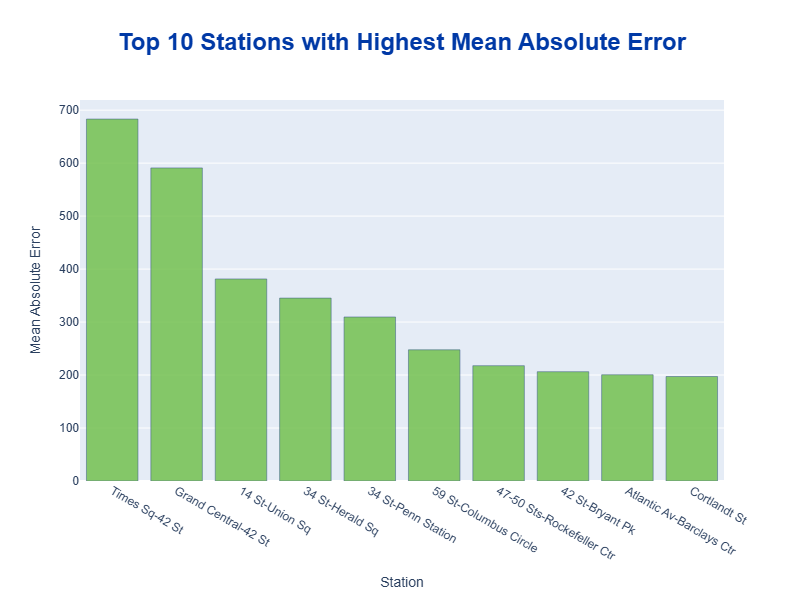

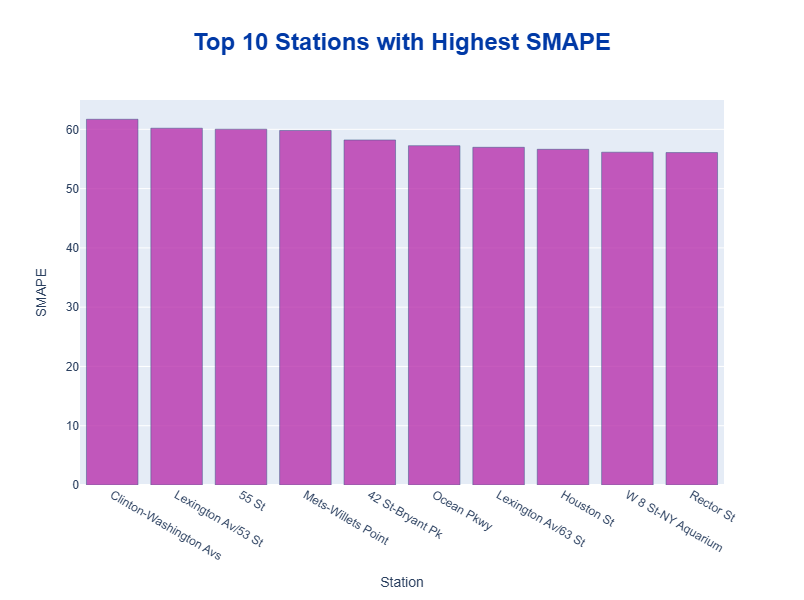

In [100]:
results = main_analysis(merged_df)
show_all_visualizations(results)


In [102]:
# Save the figure as an HTML file
pio.write_html(results['spatial_errors']['top_stations_mae'], file="top_10_station_mae.html", full_html=True)
pio.write_html(results['spatial_errors']['top_stations_smape'], file="top_10_station_smape.html", full_html=True)